# LSTM Covid-19 Data Analysis

This notebook walks through implementing lstm neural networks as well as data loading on JHU's covid-19 time-series data, maintained here: https://github.com/CSSEGISandData/COVID-19. In the this walk-through, we use our predictor and data loader classes that are in the ML module in this repo.

In [1]:
# basic python libs
import os, wget, json

# deep learning frameowkr tools
import torch
from torch import nn, optim

# data analysis libs
import numpy as np, pandas as pd

# visualization libs
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

# ML pre-processing
from sklearn.preprocessing import MinMaxScaler

In [2]:
# our predictor and data loader
from ML.lstm_torch import LSTM_data_loader, LSTM_Predictor, train_lstm, predict_future

import warnings
warnings.filterwarnings('ignore')

Set all of our visualization preferences.

In [3]:
%matplotlib inline

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.6)
sns.set_palette(sns.color_palette("husl", 8))

rcParams['figure.figsize'] = 16, 12
register_matplotlib_converters()

In [5]:
# set our random seed
RANDOM_SEED = 26
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

For doing a country-level analysis, we'll want to download the most recent data from the JHU database. That said, up until 3/22, the researchers were reporting state level data. There was functionality built into the the data-loaidng class to subset down to the state-level for project covid -19 growth for each state.

In [6]:
if os.path.isfile('time_series_covid19_confirmed_global.csv'):
    os.remove('time_series_covid19_confirmed_global.csv')
    
wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

'time_series_covid19_confirmed_global.csv'

## World covid-19 Growth Analysis

Lets start out with not subsetting our data for modeling -- let's aggregate all of our information over the entire world, largely because as we have more data points and will have a better fitting model. Since we're using long short-term memory machine networks in order to model out confirmed-case growth, if we have a bunch of 0s at the beginning of out time-series data and it begins to ramp up quickly, our model is going to have a hard time fitting to the sudden jump. If we capture as much of that as possible (i.e. use as much of the data as possible) we should see better results.

In [7]:
tdf = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [8]:
tdf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


The first thing we're going to use is the `LSTM_data_loader` class. Since we're subsetting in a couple different way, for useability we wrapped some of the basic manipulations into a data loader class. Most importantly, we're passing in a dataframe of the format above (how JHU has been provindg their data). If we pass this in and no other arguments, we will simply prep our data to model at the world-level. After that, we can pass in a country name that exists in the `Country/Region` column that we would like to subset by. If we use one of the archived data sets that contains state-level information, we can pass in a state abbreviation as well. In order to do this, we also need to pass in a dictionary where the abbreviation maps to the name of the state (i.e {'WA' : 'Washington'}. This dictionary just helps capture all instances in the dataframe where the state is metnioned).

In [9]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     state_mapper=None)

We still need to call the `subset_df` method off of our LSTM data loader as it still removes some columns off of our data that we're not going to want for the next step.

In [10]:
world_data_loader.subset_df()
world_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,0,0,0,0,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,0,0,0,0,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,0,0,0,0,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,0,0,0,0,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


For plotting out our data, making predictions, and generally working with our data, it's more convenient to have our data in a datetime format, so we transfor switch our axes and cast out time-step information to a date-time type. The `delta` argument determines if our new cases are either the cumulative amount of cases in a country, or the amount of new daily cases. This changes the coontext of what we're predicting and modeling as well. For this, we're sticking with cumulative cases as typically these networks have an easier time fitting to smoother curves. That said, daily differences more excplicitly capture factors such as momemntum and negative swings.

In [11]:
world_data_loader.transform_df_datetime(delta=False)
world_data_loader.df.head()

Data in cumulative


2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [12]:
len(world_data_loader.df)

65

Since we just packaged up a pandas dataframe inside of our loading class, we can still call easy pandas lotting features off of it. Inspecting the plot, we can see that there is significant momentum heading into February (the spike in cases in China) and a drop (a subsuquent dropping off ocf new reported cases there). At that point though, we can see the virus spread picking up again as it had reached other nations.

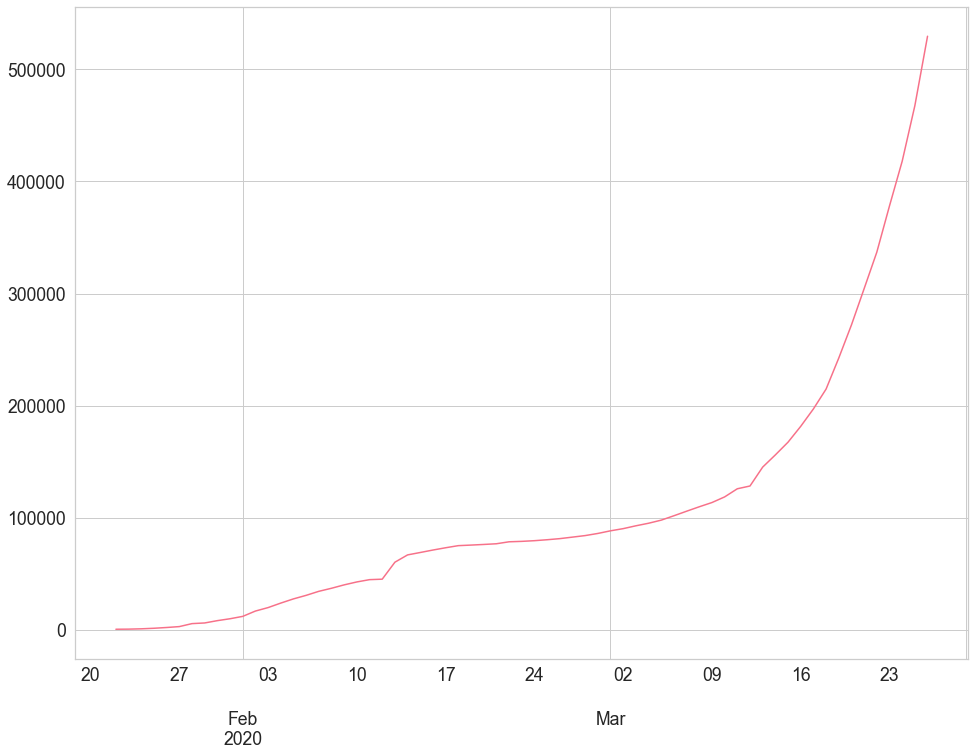

In [13]:
world_data_loader.df.plot(label="Confirmed Cases")

We can then call a method in the class to create our training and testing data sets. Pass in however much you wantfor the training data, but now we only have 56 days, forthis example I'm just going to pass in the last 5. The default value in the method is 0, which will not create a test data.

In [14]:
world_data_loader.gen_data_sets(test_data_size=7)

We then extract these data sets data sets and do some conversions into torch tensors.

In [15]:
X_train, y_train = world_data_loader.set_seq(train=True, sequence_lenth=3)
X_test, y_test = world_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [17]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=500)

Epoch 0 train loss: 5.837465763092041 test loss: 8.596288681030273
Epoch 50 train loss: 16.90916633605957 test loss: 0.06342935562133789
Epoch 100 train loss: 1.9627408981323242 test loss: 5.070084571838379
Epoch 150 train loss: 1.6630772352218628 test loss: 4.149226188659668
Epoch 200 train loss: 3.6394448280334473 test loss: 4.970938205718994
Epoch 250 train loss: 1.6675400733947754 test loss: 3.8361194133758545
Epoch 300 train loss: 0.15091942250728607 test loss: 0.46622341871261597
Epoch 350 train loss: 0.13554413616657257 test loss: 1.2385358810424805
Epoch 400 train loss: 0.1448635756969452 test loss: 1.2741453647613525
Epoch 450 train loss: 0.1482270509004593 test loss: 1.2387213706970215


In [18]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = world_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[378235.03 418045.   467653.  ]
[341302.96863794 383861.14757657 425913.2054925 ]


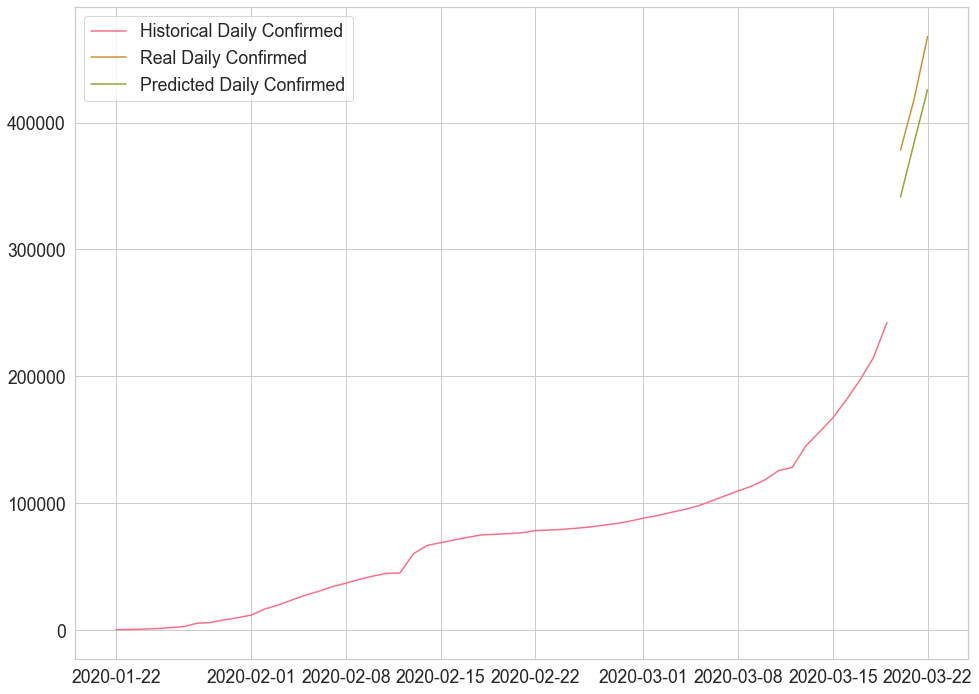

In [19]:
plt.plot(
  world_data_loader.df.index[:len(world_data_loader.train_data)],
  world_data_loader.scaler.inverse_transform(world_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## World - Future

For our future, prediction, we the only real modifications that we make to our previous analysis is that we keep all of our data as training data for a better fit, and see what the model outputs!

In [20]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     state_mapper=None)

world_data_loader.subset_df()

world_data_loader.transform_df_datetime(delta=True)

world_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = world_data_loader.set_seq(train=True, sequence_lenth=3)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 2.7606120109558105
Epoch 50 train loss: 0.8658325672149658
Epoch 100 train loss: 0.49683648347854614
Epoch 150 train loss: 0.4703710079193115
Epoch 200 train loss: 0.4707976281642914
Epoch 250 train loss: 0.4681796729564667
Epoch 300 train loss: 0.46275627613067627
Epoch 350 train loss: 0.6331944465637207
Epoch 400 train loss: 0.49717068672180176
Epoch 450 train loss: 0.47772645950317383


In [21]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[36681.87985861 39111.55327392 42101.32740927 45578.92930162
 49514.11621016 53901.75000197 58751.03803432 64078.25720465
 69901.43520892 76235.87586915]


After all that... our model looks pretty inear, predicting an incrase of ~10k cases a day. 

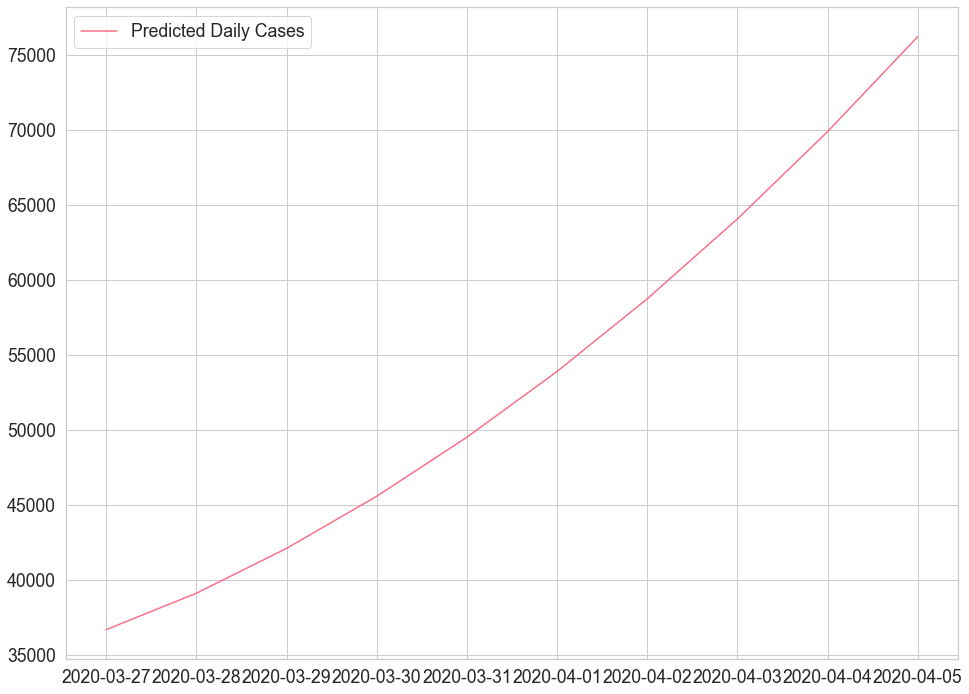

In [22]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

And our data and predictions together.

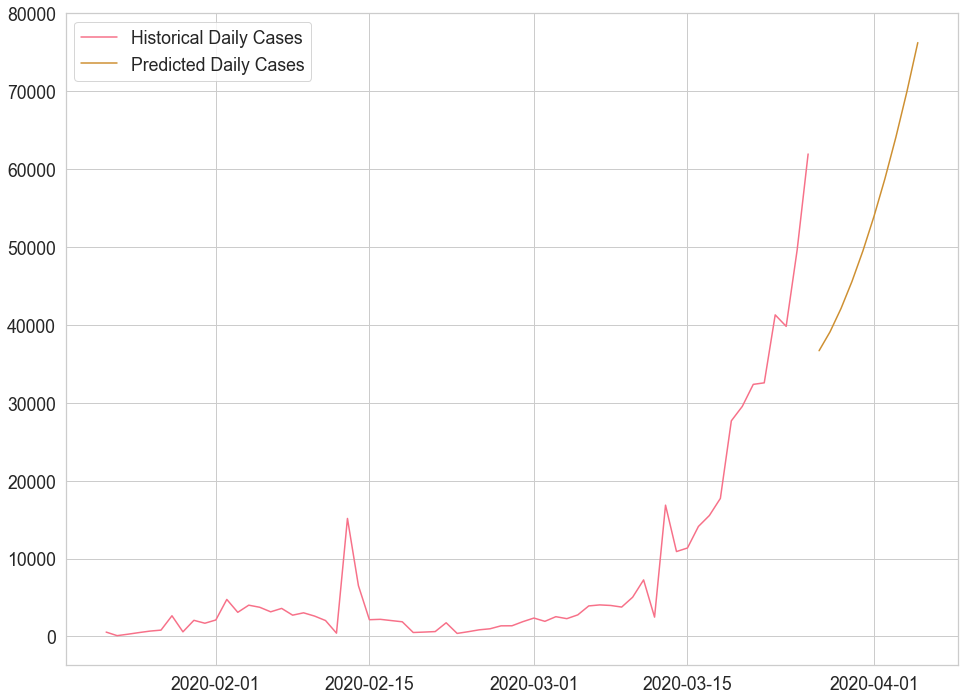

In [23]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

## Italian Analysis

Okay, lets try something a bit harder that ahs considerabley less data then then aggergating over the whole world. Lets do Italy.

In [24]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country='Italy',
                                     state_mapper=None)

In [25]:
italy_data_loader.subset_df()
italy_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,0,0,0,0,0,0,0,0,0,2,...,31506,35713,41035,47021,53578,59138,63927,69176,74386,80589


In [26]:
italy_data_loader.transform_df_datetime(delta=True)
italy_data_loader.df.head()

Data is converted to daily delta


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

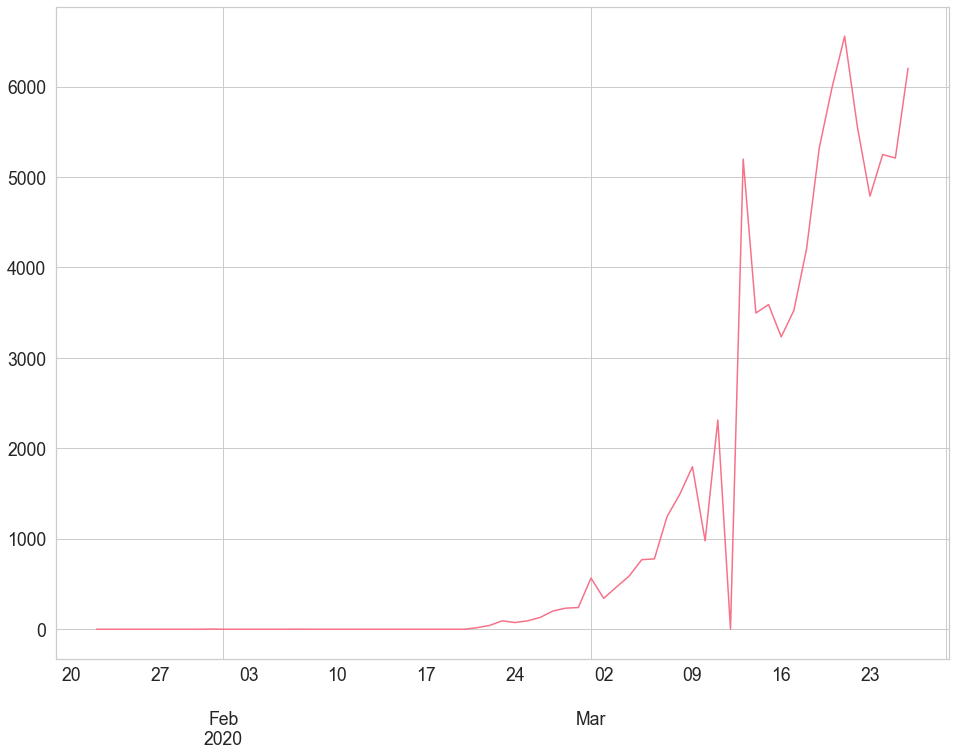

In [27]:
italy_data_loader.df.plot(label="Confirmed Cases")

In [28]:
italy_data_loader.gen_data_sets(test_data_size=7)

In [29]:
X_train, y_train = italy_data_loader.set_seq(train=True,sequence_lenth=3)
X_test, y_test = italy_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [30]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [31]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 3.707695245742798 test loss: 2.6873226165771484
Epoch 50 train loss: 1.0260292291641235 test loss: 0.07620556652545929
Epoch 100 train loss: 0.8948269486427307 test loss: 0.0024764463305473328
Epoch 150 train loss: 0.89437335729599 test loss: 0.0038164244033396244
Epoch 200 train loss: 0.9270889759063721 test loss: 0.016119029372930527
Epoch 250 train loss: 0.9349449276924133 test loss: 0.011479988694190979


In [32]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = italy_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[4789. 5249. 5210.]
[5547.54369092 6079.10494494 6611.53537059]


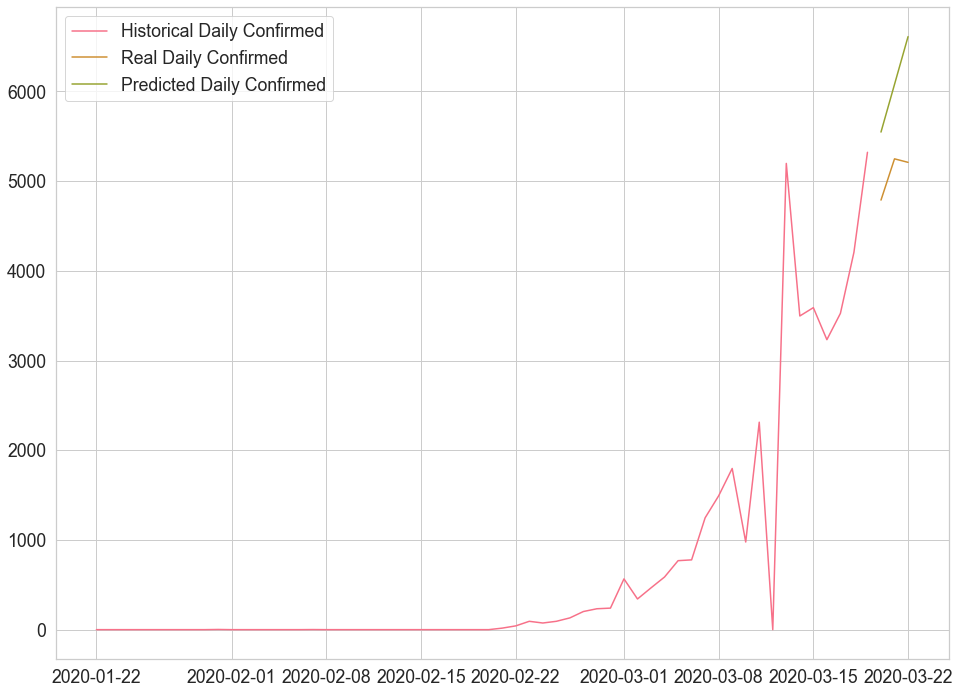

In [33]:
plt.plot(
  italy_data_loader.df.index[:len(italy_data_loader.train_data)],
  italy_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## Italy - Future

In [34]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country="Italy",
                                     state_mapper=None)

italy_data_loader.subset_df()

italy_data_loader.transform_df_datetime(delta=True)

italy_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = italy_data_loader.set_seq(train=True,sequence_lenth=3)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 6.956713676452637
Epoch 50 train loss: 1.0143579244613647
Epoch 100 train loss: 1.1858398914337158
Epoch 150 train loss: 0.8807960748672485
Epoch 200 train loss: 1.0085400342941284
Epoch 250 train loss: 0.7609849572181702
Epoch 300 train loss: 0.6366156339645386
Epoch 350 train loss: 0.5394593477249146
Epoch 400 train loss: 0.5103209614753723
Epoch 450 train loss: 0.547364354133606


In [35]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[6108.87075663 6229.92258811 6341.51170039 6440.51850712 6526.71476495
 6600.95638645 6664.50887156 6718.72135735 6764.87185025 6804.11563683]


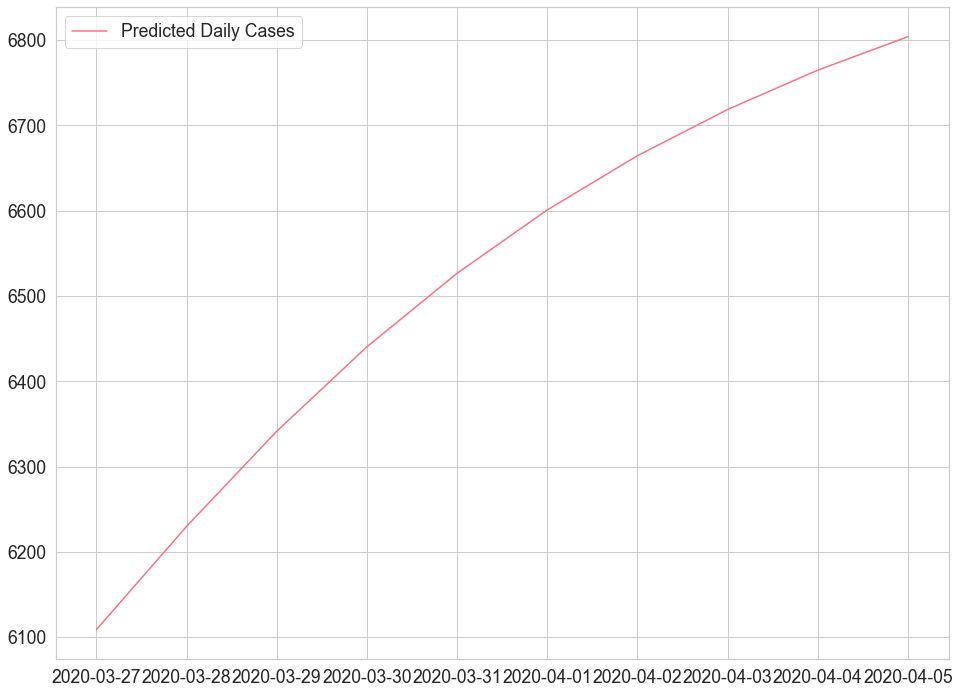

In [36]:
predicted_index = pd.date_range(
  start=italy_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

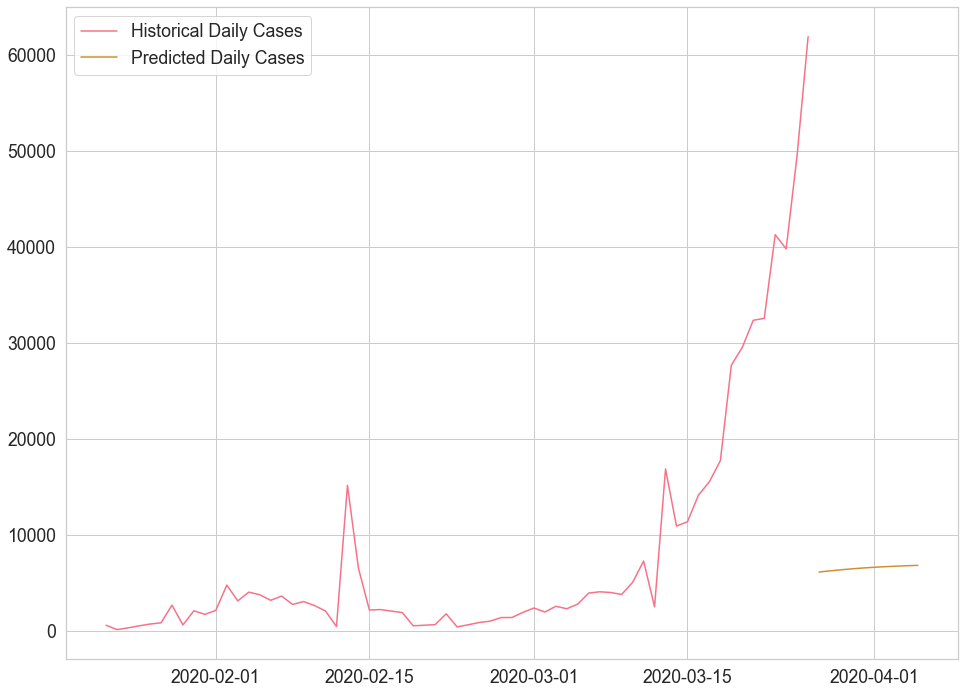

In [37]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

Lets collect data for prediction for all of the countries in our data set.

## US States Analysis

### CA

To do our analyses on US States, we can just feed in an abbreviation, but we have a good amount of disparatae naming that takes place in our data set that looks like so.

In [38]:
states_df = pd.read_csv('./data/jhu_data/time_series_19-covid-Confirmed_3_22.csv')
states_df.drop(columns=['Unnamed: 0'],inplace=True)

In [39]:
# some state names
states_df[states_df['Country/Region']=='US'][:5]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,568,572,643,904,1076,1014,1376,1524,1793,1996
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,421,525,732,967,1706,2495,5365,8310,11710,15793
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,282,340,426,557,698,751,952,1177,1364,1642
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,123,138,164,197,218,218,328,413,525,646
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,47,47,47,47,49,49,49


In [40]:
# some mixed types
states_df[states_df['Country/Region']=='US'][-5:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,3,5,5,5,5,5,14,21,23
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,3,3,3,5,12,14,15,27
448,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,1,1,1,2,2,3,3,3,3
491,United States Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,US,US,37.0902,-95.7129,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So lets get some of this from a hand json we were already using for geospatial information in our visualization to get some name metadata.

In [41]:
with open('./data/geo_data/us-states.json', 'r') as f:
    us_states = json.load(f)
    
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

First, lets pick a state that has a considerable outbreak, California.

In [42]:
wa_data_loader = LSTM_data_loader(df=states_df,
                          region_abr='WA',
                          country='US',
                          state_mapper=state_mapper)

In [43]:
wa_data_loader.subset_df()
wa_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,1,1,1,1,1,1,1,1,1,1,...,568,572,643,904,1076,1014,1376,1524,1793,1996


In [44]:
wa_data_loader.transform_df_datetime()
wa_data_loader.df.head()

Data in cumulative


2020-01-22    1
2020-01-23    1
2020-01-24    1
2020-01-25    1
2020-01-26    1
dtype: int64

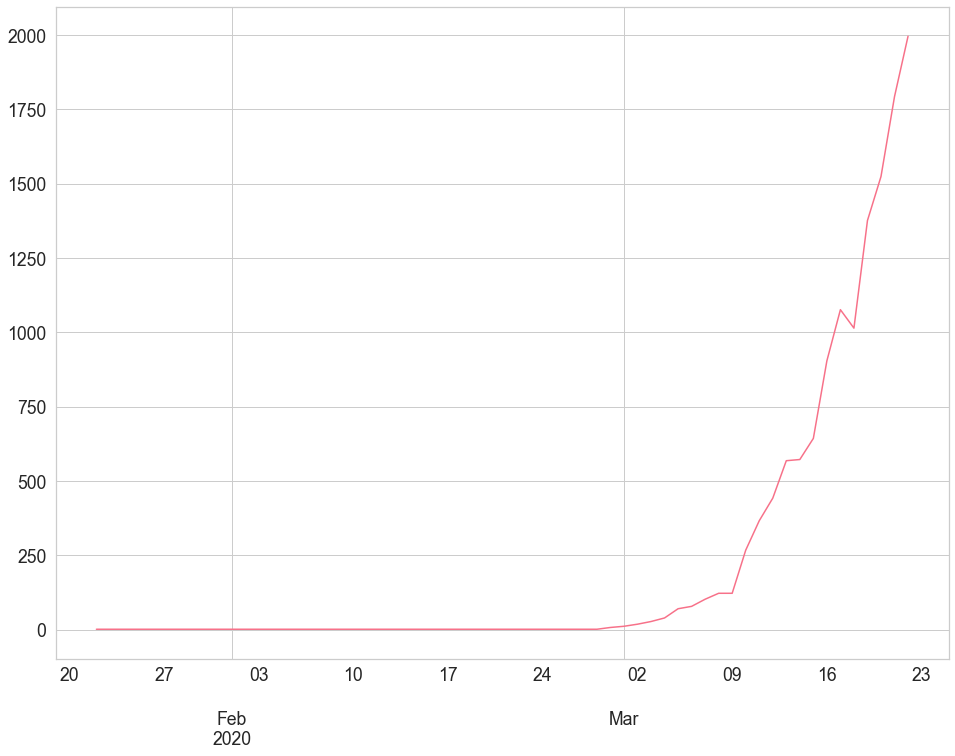

In [45]:
wa_data_loader.df.plot(label="Confirmed Cases")

In [46]:
wa_data_loader.gen_data_sets(test_data_size=7)

In [47]:
wa_data_loader.test_data

array([[1.40654206],
       [1.67445483],
       [1.57788162],
       [2.14174455],
       [2.37227414],
       [2.79127726],
       [3.10747664]])

In [48]:
X_train, y_train = wa_data_loader.set_seq(train=True, sequence_lenth=3)
X_test, y_test = wa_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [49]:
len(X_train)

50

In [50]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [51]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 2.411163806915283 test loss: 17.456514358520508
Epoch 50 train loss: 0.6631855368614197 test loss: 3.1376967430114746
Epoch 100 train loss: 0.45877087116241455 test loss: 1.4010326862335205
Epoch 150 train loss: 0.44648244976997375 test loss: 1.3606666326522827
Epoch 200 train loss: 0.4474634528160095 test loss: 1.4032245874404907
Epoch 250 train loss: 0.453236848115921 test loss: 1.2750556468963623


In [52]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = wa_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = wa_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[1376.     1524.     1792.9999]
[1597.89491653 1859.23181629 2140.10957146]


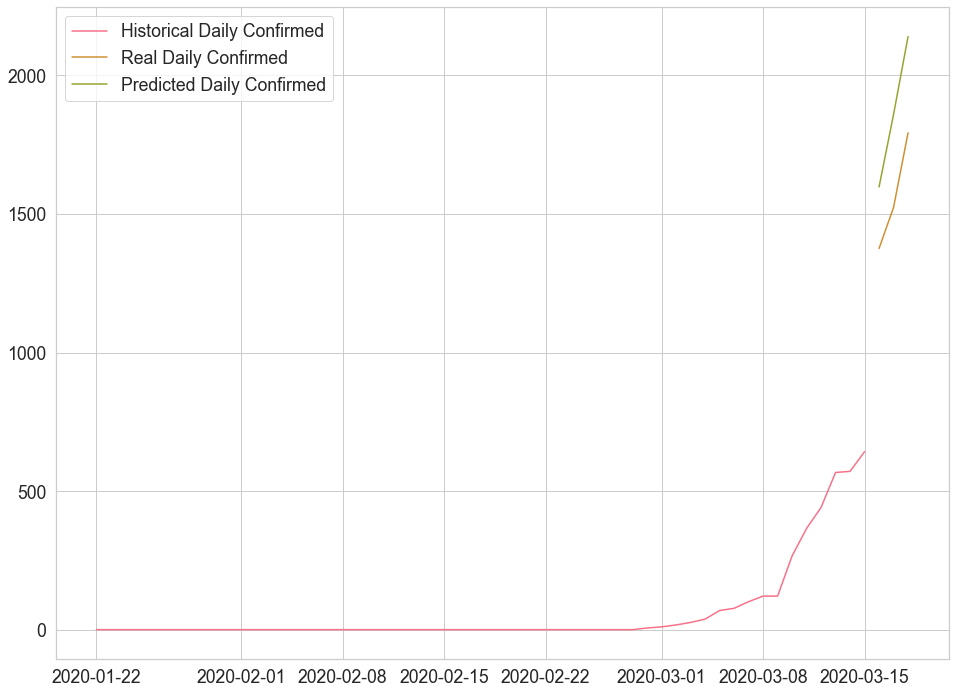

In [53]:
plt.plot(
  wa_data_loader.df.index[:len(wa_data_loader.train_data)],
  wa_data_loader.scaler.inverse_transform(wa_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  wa_data_loader.df.index[len(wa_data_loader.train_data):len(wa_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  wa_data_loader.df.index[len(wa_data_loader.train_data):len(wa_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

### CO

Lets try a state with some cases, but considerable less data, Colorado.

In [54]:
co_data_loader = LSTM_data_loader(df=states_df,
                          region_abr='CO',
                          country='US',
                          state_mapper=state_mapper)

In [55]:
co_data_loader.subset_df()
co_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,0,0,0,0,0,0,0,0,0,0,...,49,101,131,160,160,184,277,363,390,476


In [56]:
co_data_loader.transform_df_datetime()
co_data_loader.df.head()

Data in cumulative


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

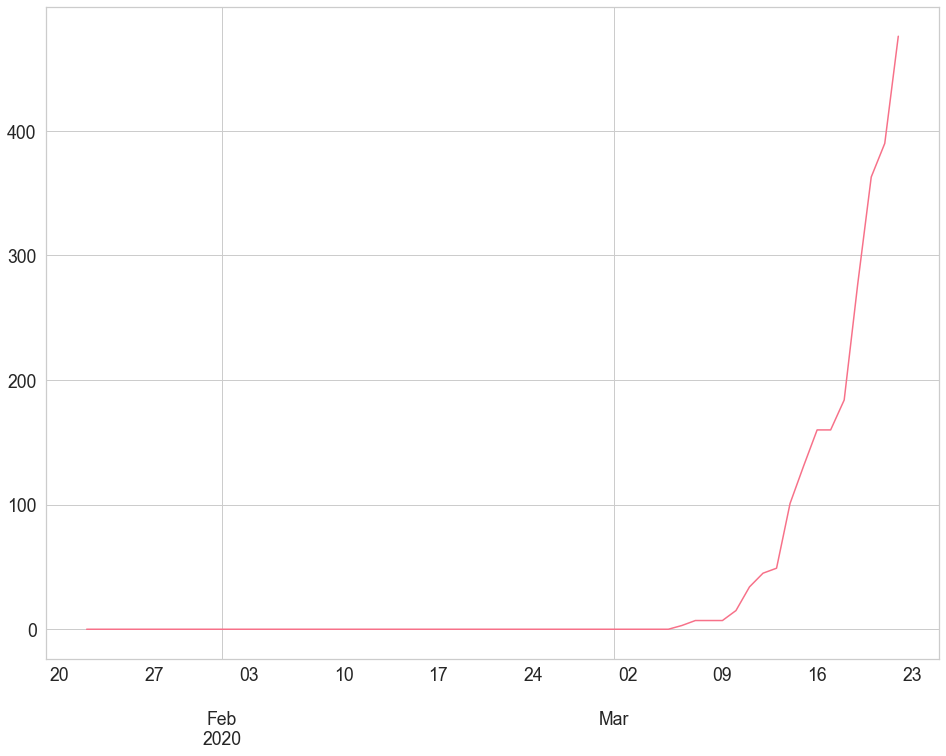

In [57]:
co_data_loader.df.plot(label="Confirmed Cases")

In [58]:
co_data_loader.gen_data_sets(test_data_size=0)

In [59]:
X_train, y_train = co_data_loader.set_seq(train=True, sequence_lenth=3)
# X_test, y_test = co_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_test = torch.from_numpy(y_test).float()

In [60]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [ ]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=300)

Epoch 0 train loss: 2.207463264465332
Epoch 50 train loss: 0.5127536654472351
Epoch 100 train loss: 0.3723390996456146
Epoch 150 train loss: 0.3793192505836487
Epoch 200 train loss: 0.38776540756225586


In [ ]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = co_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

In [ ]:
predicted_index = pd.date_range(
  start=co_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

In [ ]:
plt.plot(co_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()